**Machine Learning for Time Series (Master MVA)**

- TP1, Thursday 16<sup>th</sup> October 2025
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we focus on the task of **clustering time series**. Through several examples, we will highlight the specific challenges that arise from the **temporal structure** of the data. 

We will address these challenges using several key concepts introduced in the lessons:

- Dynamic Time Warping (DTW)

- Convolutional Dictionary Learning

- Feature Extraction

- Feature Selection

# Setup

**Imports**

In [15]:
from itertools import tee

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

import numpy as np 
import pandas as pd

#import a data loader
from aeon.datasets import load_classification
#dtw computations
from dtw import dtw
#compare computation times
import time
#hierarchical clustering
from scipy.cluster import hierarchy
from scipy.stats import f_oneway 


from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import adjusted_rand_score, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

from alphacsc import learn_d_z
try:
    from alphacsc.utils import construct_X
except:
    from alphacsc.utils.convolution import construct_X

from scipy.signal import argrelmax

**Utilitary functions**

In [16]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

def get_n_largest(
    arr: np.ndarray, n_largest: int = 3) -> (np.ndarray, np.ndarray):
    """Return the n largest values and associated indexes of an array.

    (In decreasing order of value.)
    """
    indexes = np.argsort(arr)[-n_largest:][::-1]
    if n_largest == 1:
        indexes = np.array(indexes)
    values = np.take(arr, indexes)
    return values, indexes

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_largest_local_max(signal1D: np.ndarray, order: int = 1):
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_index = all_local_max_indexes[all_local_max.argsort()[-1]]

    return signal1D[largest_local_max_index], largest_local_max_index

# Clustering in Time Series

**Clustering** is an unsupervised learning task that aims to **group similar data points** together into clusters, so that objects in the same cluster are more similar to each other than to those in different clusters.

### How to define similarity for time series ?

For time series, defining a meaningful similarity (or distance) is challenging. Typical issues include:

- **Amplitude differences and offset shifts**. *Problem:* Series may have the same shape but different offsets or amplitudes.
*Solution:* Normalize series (e.g., z-normalization) to focus on relative shape rather than absolute values.

- **Time shifts (temporal misalignment)**. 
*Problem:* Similar events may occur at slightly different times.
*Solution:* Use alignment-based measures such as Dynamic Time Warping (DTW).

# 1. DTW vs Euclidean Distance

##  Dataset example

FiftyWords is a data set of word outlines taken from the George
Washington library by T. Rath and used in the paper "Word image
matching using dynamic time warping", CVPR 2003.

Each case is a word. A series is formed by taking the height
profile of the word.

![image](alexandria.png)

Here, we only deal with the top profile (in red).

In [17]:
#loading data
profiles, labels= load_classification("FiftyWords")
profiles=np.squeeze(profiles)

# normalize signals (zero mean, unit variance).
profiles -= profiles.mean(axis=1).reshape(-1,1)
profiles /= profiles.std(axis=1).reshape(-1,1)

In [44]:
print(profiles.shape)

(905, 270)


It's a row based sampling

Let's visualize two examples from the same class.

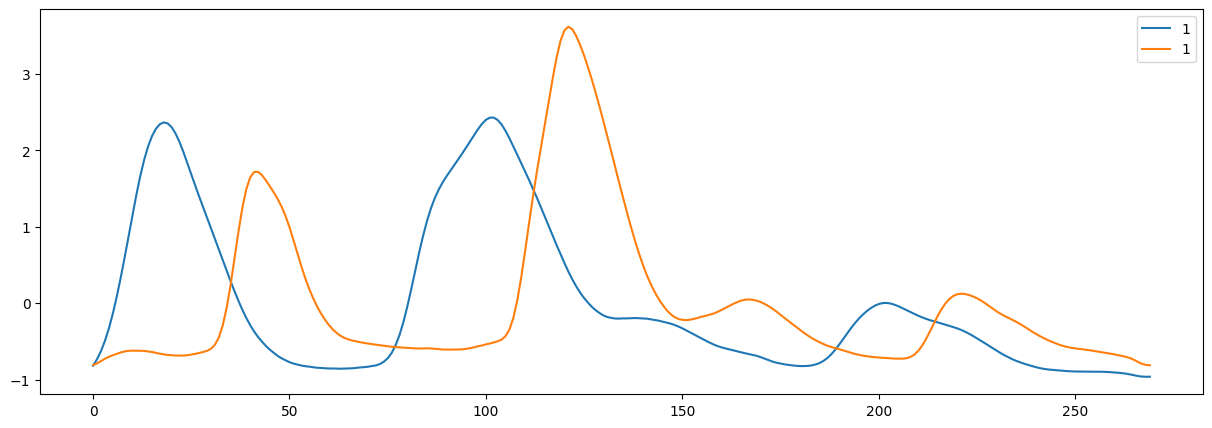

In [18]:
labels_1=np.where(labels=='1')[0]
word_1, y_1= profiles[labels_1[0]], labels[labels_1[0]]
word_2, y_2=profiles[labels_1[3]], labels[labels_1[3]]

figsize=(15, 5)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(word_1, label=y_1)
ax.plot(word_2, label=y_2)
_ = plt.legend()

## DTW between 2 signals

In [22]:
print(word_1.shape)
print(word_2.shape)

(270,)
(270,)


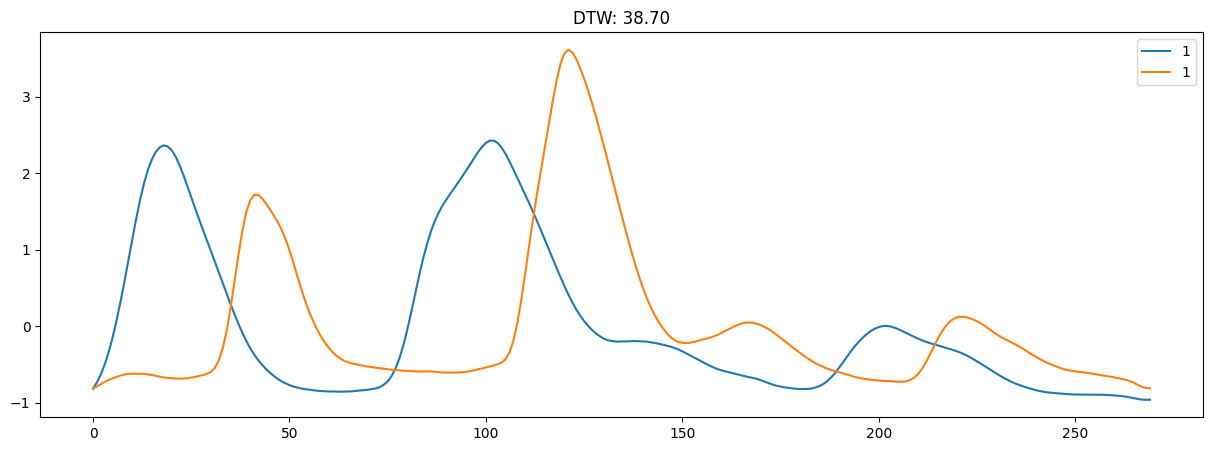

In [19]:
alignment = dtw(word_1, word_2, keep_internals=True)
figsize=(15, 5)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(word_1, label=y_1)
ax.plot(word_2, label=y_2)
plt.title(f"DTW: {alignment.distance:.2f}")
_ = plt.legend()

<Axes: >

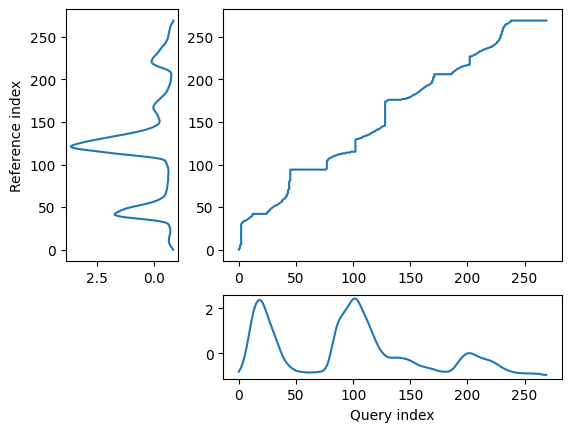

In [20]:
alignment.plot(type="threeway")

1 is late so we are on the upper part of the upper quadrant

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

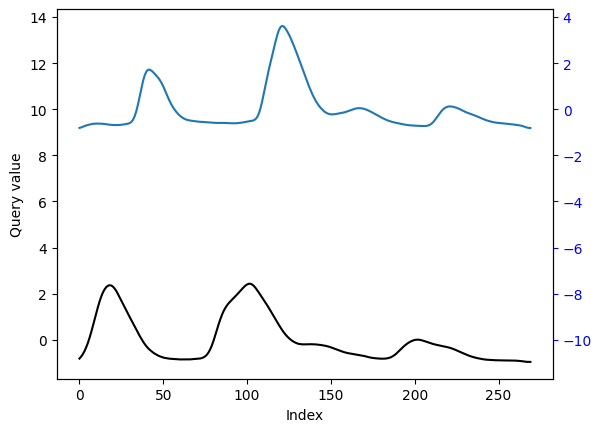

In [21]:
alignment.plot(type="twoway", offset=10)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Write a function which computes the DTW distance between two signals using the dtw module: <tt>get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float</tt>.</p>
</div>

In [24]:
## dtw() returns an object with the following attributes:

def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float:
    distance = dtw(signal_1, signal_2, keep_internals=True).distance
    return distance

def get_euclidean_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float:
    distance = np.linalg.norm(signal_1 - signal_2)
    return distance
    

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Choose one of the two words and plot the most similar and the most dissimilar, according to the DTW. In addition, print the associated labels.</p>
</div>

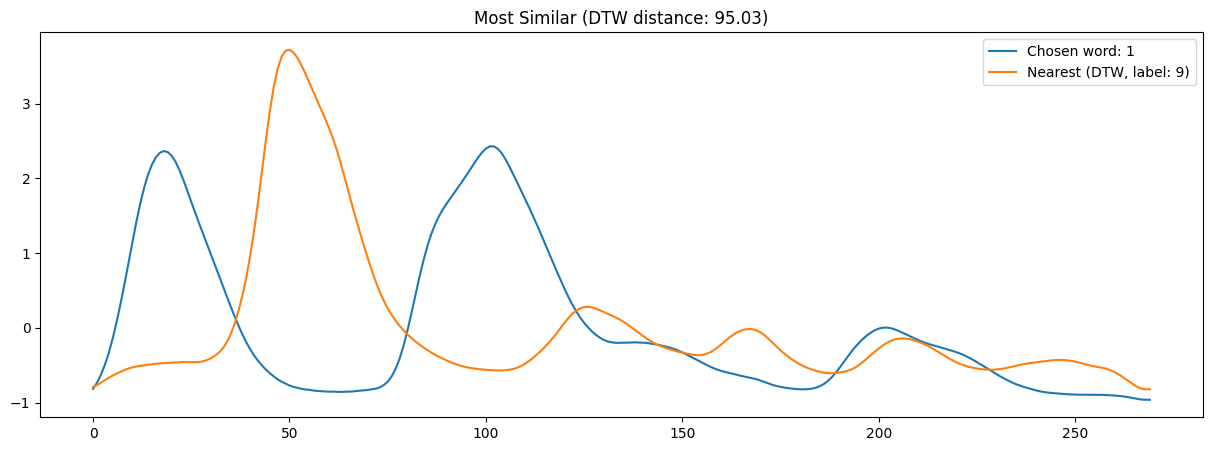

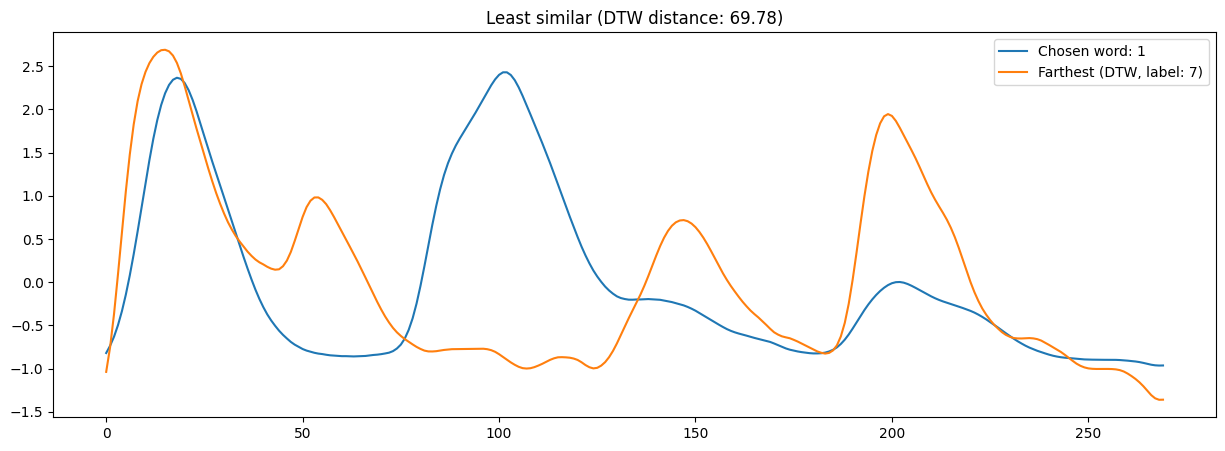

In [36]:
chosen_word = word_1

def nearest_neighbor_dtw(word: np.ndarray, profiles: np.ndarray, labels: np.ndarray)->tuple[np.ndarray, np.ndarray]:
    distances = np.array([get_dtw_distance(word, profiles[k,:]) for k in range(2,profiles.shape[0])])
    nearest_neighbor_index = np.argmin(distances)
    return profiles[nearest_neighbor_index,:], labels[nearest_neighbor_index]


def nearest_neighbor_euclidean(word: np.ndarray, profiles: np.ndarray, labels: np.ndarray)->tuple[np.ndarray, np.ndarray]:
    distances = np.array([get_euclidean_distance(word, profiles[k,:]) for k in range(2,profiles.shape[0])])
    nearest_neighbor_index = np.argmin(distances)
    return profiles[nearest_neighbor_index,:], labels[nearest_neighbor_index]


def farthest_neighbor_dtw(word: np.ndarray, profiles: np.ndarray, labels: np.ndarray)->tuple[np.ndarray, np.ndarray]:
    distances = np.array([get_dtw_distance(word, profiles[k,:]) for k in range(2,profiles.shape[0])])
    farthest_neighbor_index = np.argmax(distances)
    return profiles[farthest_neighbor_index,:], labels[farthest_neighbor_index]


def farthest_neighbor_euclidean(word: np.ndarray, profiles: np.ndarray, labels: np.ndarray)->tuple[np.ndarray, np.ndarray]:
    distances = np.array([get_euclidean_distance(word, profiles[k,:]) for k in range(2,profiles.shape[0])])
    farthest_neighbor_index = np.argmax(distances)
    return profiles[farthest_neighbor_index,:], labels[farthest_neighbor_index]



nearest_neighbor_word_dtw, nearest_neighbor_label_dtw = nearest_neighbor_dtw(word_1, profiles, labels)
farthest_neighbor_word_dtw, farthest_neighbor_label_dtw = farthest_neighbor_dtw(word_1, profiles, labels)




dtw_distance_nearest = get_dtw_distance(word_1, nearest_neighbor_word_dtw)
dtw_distance_farthest = get_dtw_distance(word_1, farthest_neighbor_word_dtw)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(word_1, label=f"Chosen word: {y_1}")
ax.plot(nearest_neighbor_word_dtw, label=f"Nearest (DTW, label: {nearest_neighbor_label_dtw})")
plt.title(f"Most Similar (DTW distance: {dtw_distance_nearest:.2f})")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(word_1, label=f"Chosen word: {y_1}")
ax.plot(farthest_neighbor_word_dtw, label=f"Farthest (DTW, label: {farthest_neighbor_label_dtw})")
plt.title(f"Least similar (DTW distance: {dtw_distance_farthest:.2f})")
plt.legend()
plt.show()


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Repeat the same procedure with the Euclidean distance. Compare the results and the computation times with DTW (you may use the time module).</p>
</div>

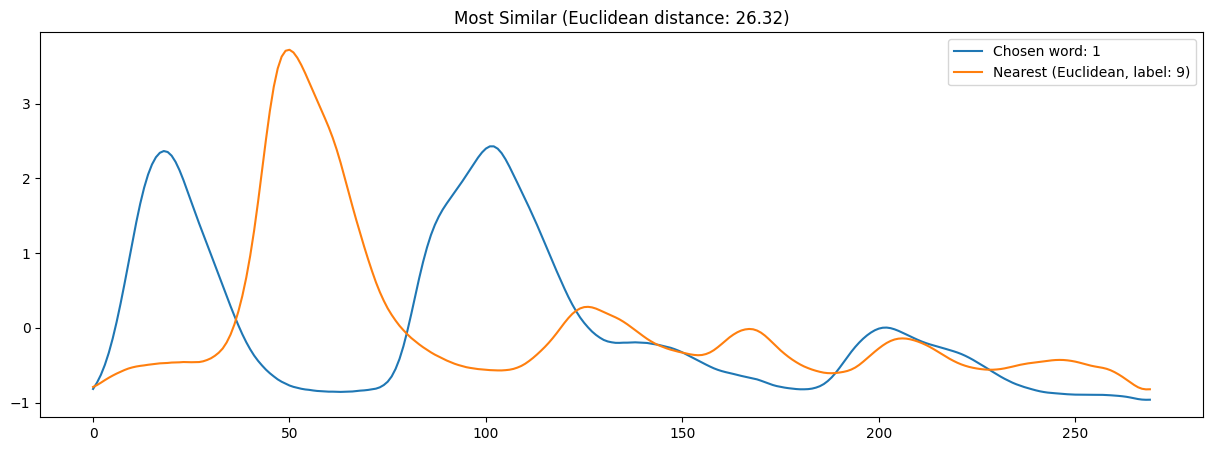

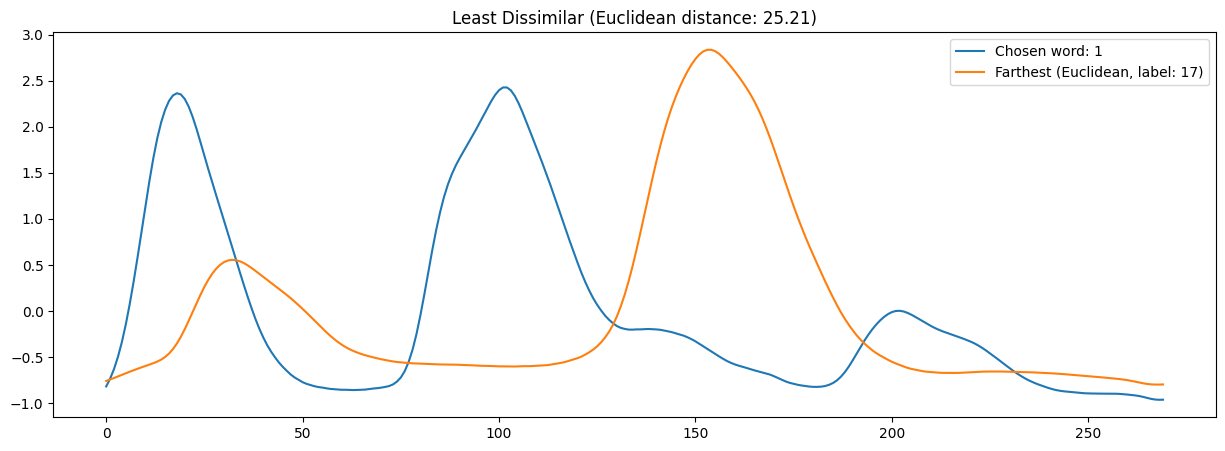

Label of chosen word: 1
Label of most similar (DTW): 9
Label of most dissimilar (DTW): 7
Label of most similar (Euclidean): 9
Label of most dissimilar (Euclidean): 17


In [37]:


nearest_neighbor_word_euclidean, nearest_neighbor_label_euclidean = nearest_neighbor_euclidean(word_1, profiles, labels)
farthest_neighbor_word_euclidean, farthest_neighbor_label_euclidean = farthest_neighbor_euclidean(word_1, profiles, labels)


euclidean_distance_nearest = get_euclidean_distance(word_1, nearest_neighbor_word_euclidean)
euclidean_distance_farthest = get_euclidean_distance(word_1, farthest_neighbor_word_euclidean)



fig, ax = plt.subplots(figsize=figsize)
ax.plot(word_1, label=f"Chosen word: {y_1}")
ax.plot(nearest_neighbor_word_euclidean, label=f"Nearest (Euclidean, label: {nearest_neighbor_label_euclidean})")
plt.title(f"Most Similar (Euclidean distance: {euclidean_distance_nearest:.2f})")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(word_1, label=f"Chosen word: {y_1}")
ax.plot(farthest_neighbor_word_euclidean, label=f"Farthest (Euclidean, label: {farthest_neighbor_label_euclidean})")
plt.title(f"Least Dissimilar (Euclidean distance: {euclidean_distance_farthest:.2f})")
plt.legend()
plt.show()

print("Label of chosen word:", y_1)
print("Label of most similar (DTW):", nearest_neighbor_label_dtw)
print("Label of most dissimilar (DTW):", farthest_neighbor_label_dtw)
print("Label of most similar (Euclidean):", nearest_neighbor_label_euclidean)
print("Label of most dissimilar (Euclidean):", farthest_neighbor_label_euclidean)



## Clustering with DTW

### Clustering a small subset

Out of the whole data set, let us choose 6 word profiles from 2 classes.

In [54]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["31", "34"])
labels_sub = labels[keep_mask]
profiles_sub = profiles[keep_mask]
# reorder by label
order_indexes = labels_sub.argsort()
labels_sub = labels_sub[order_indexes]
profiles_sub = profiles_sub[order_indexes]

In [55]:
# init
distance_matrix = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix[row, col] = get_dtw_distance(
            profiles_sub[row], profiles_sub[col]
        )
        distance_matrix[col, row] = distance_matrix[row, col]

Long to compute lol 10s

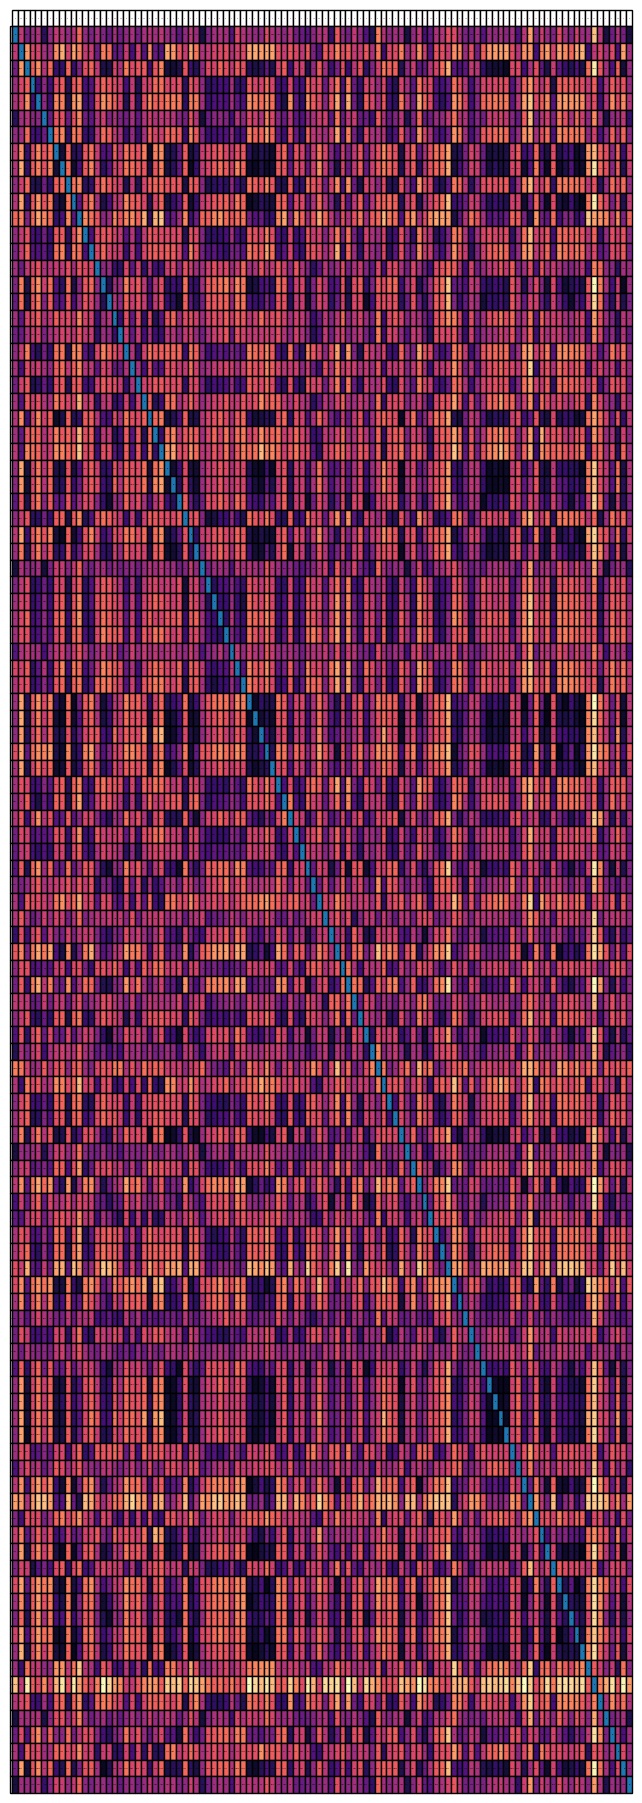

In [53]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2), labels=labels_sub
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Create the same plot (distance matrix) with the Euclidean distance instead of the DTW. What do you observe?</p>
</div>

In [41]:
euclidean_distance_matrix=np.zeros((profiles_sub.shape[0], profiles_sub.shape[0]))
for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        euclidean_distance_matrix[row, col] = get_euclidean_distance(
            profiles_sub[row], profiles_sub[col]
        )
        euclidean_distance_matrix[col, row] = euclidean_distance_matrix[row, col]

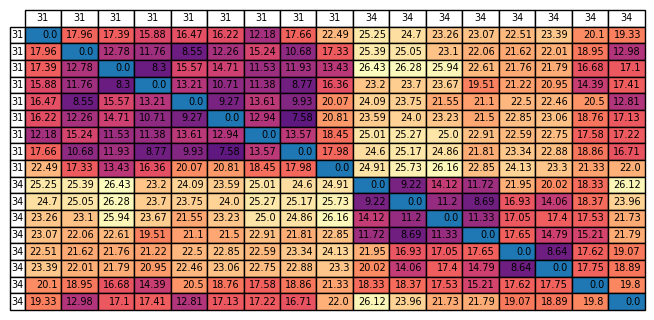

In [42]:
_ = display_distance_matrix_as_table(
    np.round(euclidean_distance_matrix, 2), labels=labels_sub
)

There is a clear clustering in the matrix, we can do spectral clustering lol, labels already cluster well

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>One of the most popular clustering algorithms is K-Means. What difficulties or limitations might you encounter when trying to use standard K-Means with DTW?</p>
</div>

We need to compute a centroid/ frechet mean at each time, which can be very long,
but we can do spectral clustering or hierarchical clustering using only pairwise distances matrix

To overcome these difficulties, we use a hierarchical clustering algorithm.

/home/janis/4A/timeseries/.venv/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


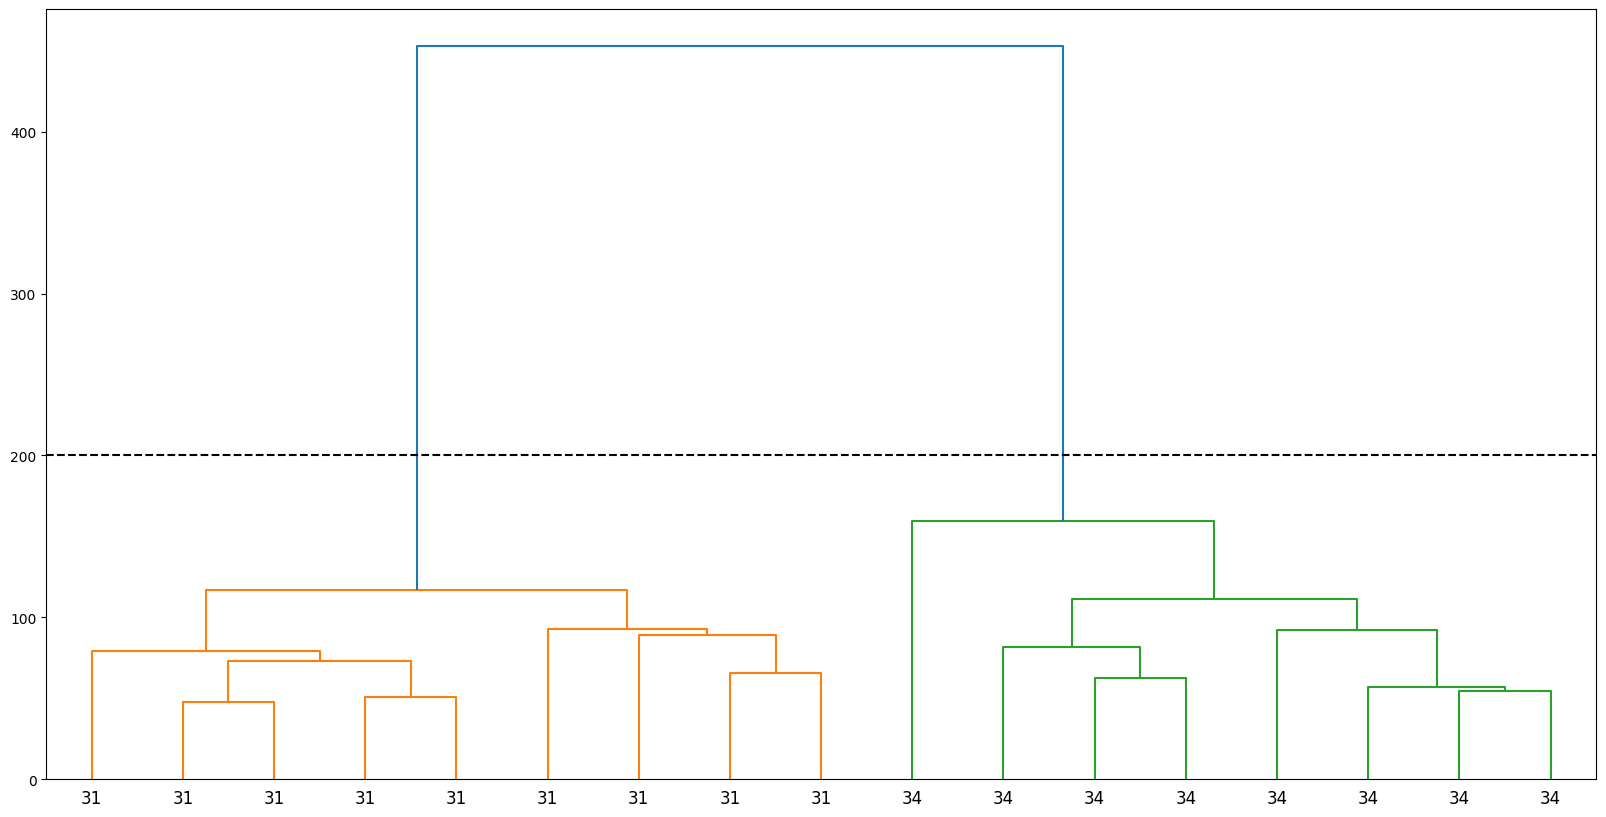

In [59]:
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(distance_matrix)

figsize=(20, 10)
fig, ax = plt.subplots(figsize=figsize)

cut_threshold = 200

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

In [60]:
labels_pred = hierarchy.fcluster(linkage, t=cut_threshold, criterion='distance')
ari=adjusted_rand_score(labels_sub,labels_pred)
ari

1.0

### Clustering on a larger subset

Using the DTW, we can cluster a large set of data (43 words).

In [61]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["4", "6", "14"])
profiles_sub = profiles[keep_mask]
labels_sub = labels[keep_mask]

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compare the clustering produced by DTW and Euclidean distance by plotting dendrograms, choosing a cut_threshold to form homogeneous clusters, and evaluating the results with the Adjusted Rand Index (ARI). Discuss which distance better captures time series similarity.</p>
</div>

In [62]:
# Instead of the previous double for loop, we can use scipy function pdist
dtw_distance_matrix = pdist(
    profiles_sub.squeeze(), metric=get_dtw_distance
)  # condensed distance matrix

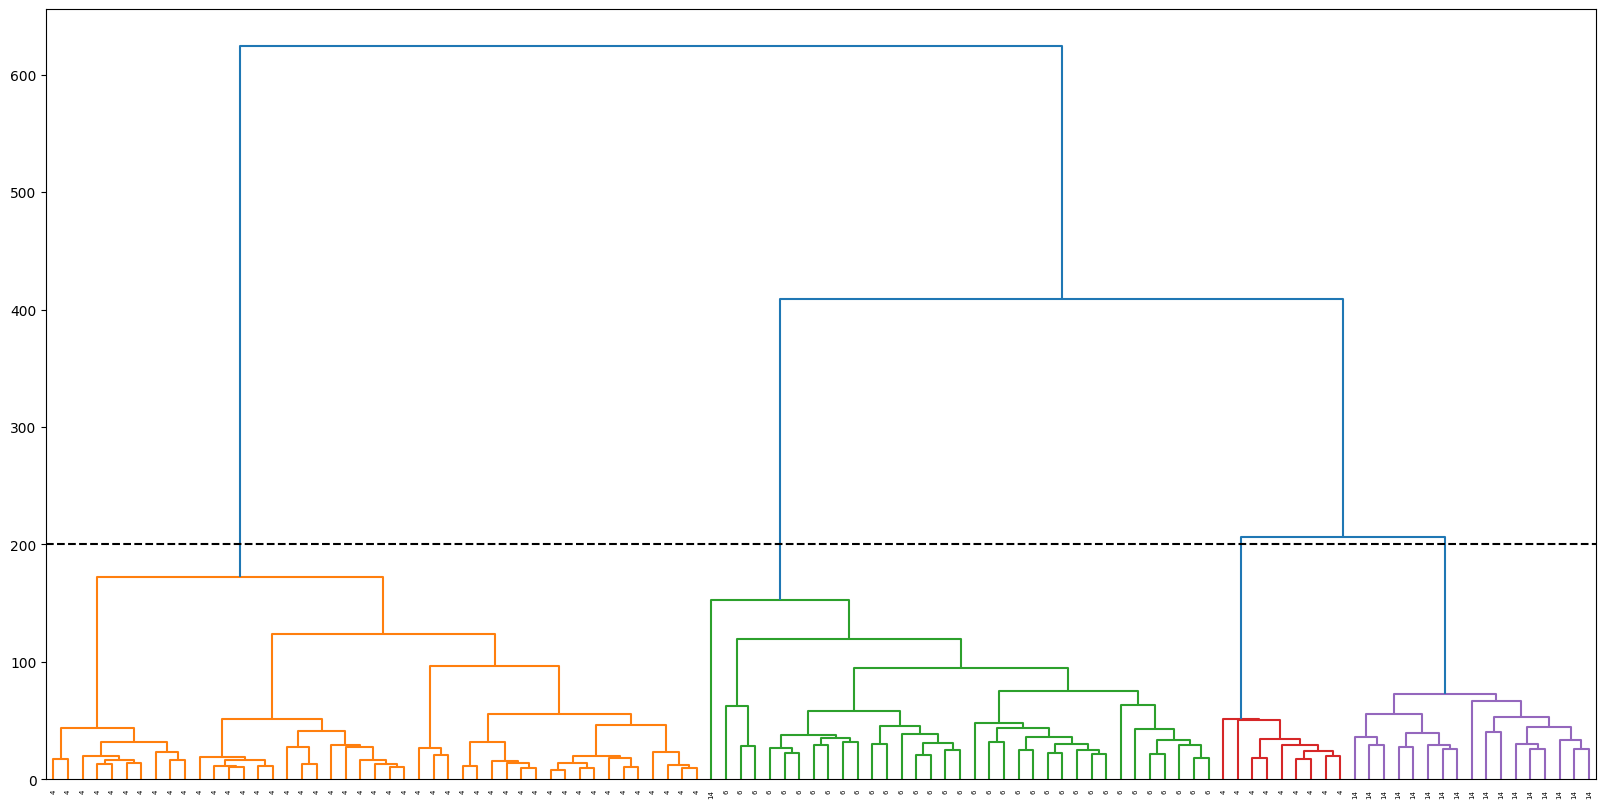

In [64]:
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(dtw_distance_matrix)

figsize=(20, 10)
fig, ax = plt.subplots(figsize=figsize)

cut_threshold = 200

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

In [66]:
# Instead of the previous double for loop, we can use scipy function pdist
euclidean_distance_matrix = pdist(
    profiles_sub.squeeze(), metric=get_euclidean_distance
)  # condensed distance matrix

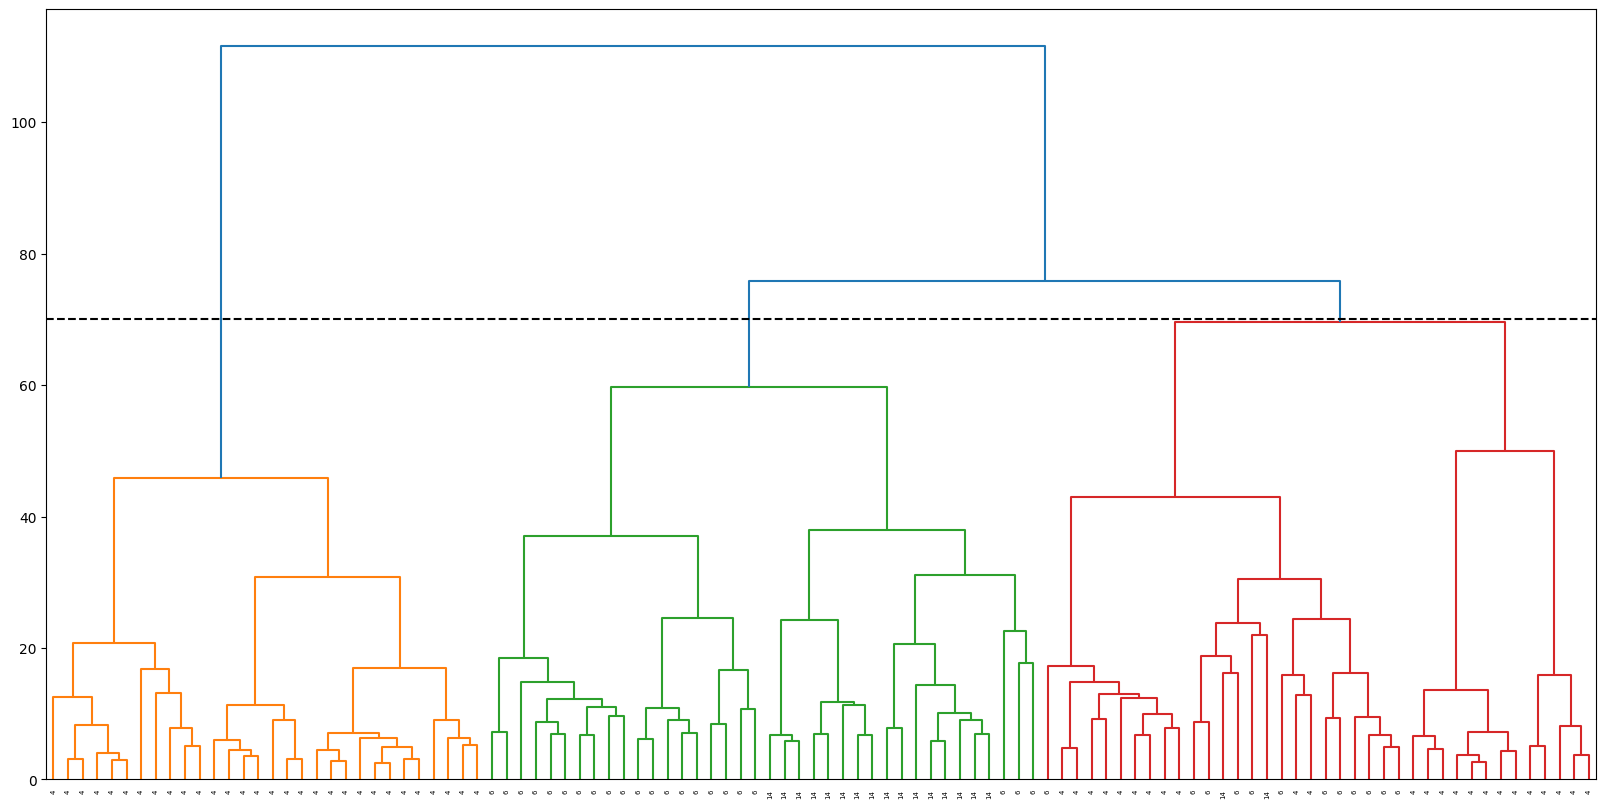

In [70]:
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(euclidean_distance_matrix)

figsize=(20, 10)
fig, ax = plt.subplots(figsize=figsize)

cut_threshold = 70

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

# 2. Clustering at the scale of atoms

Up to now, we have considered time series where class differences could be observed at the **global scale** of the signal. However, in many real-world applications the discriminative information is not visible over the whole series but rather at the level of **local patterns (atoms)**.

## Dataset example

Task is to classify the nature of the heartbeat signal.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
Each series represent the amplitude of the signal over time.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
The heart sound recordings were collected from different locations on the body. The typical four locations are aortic area, pulmonic area, tricuspid area and mitral area, but could be one of nine different locations.
The sounds were divided into two classes: normal and abnormal. The normal recordings were from healthy subjects and the abnormal ones were from patients with a confirmed cardiac diagnosis.
The patients suffer from a variety of illnesses, but typically they are heart valve defects and coronary artery disease patients.
Heart valve defects include mitral valve prolapse, mitral regurgitation, aortic stenosis and valvular surgery. All the recordings from the patients were generally labeled as abnormal.
Both healthy subjects and pathological patients include both children and adults.

Data was recorded at 2,000Hz.
Data was truncated to the shortest instance.

Original data can be found here:
https://www.physionet.org/physiobank/database/challenge/2016/

Original paper:
Goldberger AL, Amaral LA, Glass L, Hausdorff JM, Ivanov PC, Mark RG, Mietus JE, Moody GB, Peng CK, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals. circulation. 2000 Jun 13;101(23):e215-20.

Correspondence should be addressed to Ary L. Goldberger:
ary@astro.bidmc.harvard.edu

Instances: 409

Time series length: 18,530

Classes:
- Normal (110)
- Abnormal (299)


In [72]:
X, y= load_classification("BinaryHeartbeat")
X=X.squeeze()

We can plot a signal from each class (normal and abnormal).

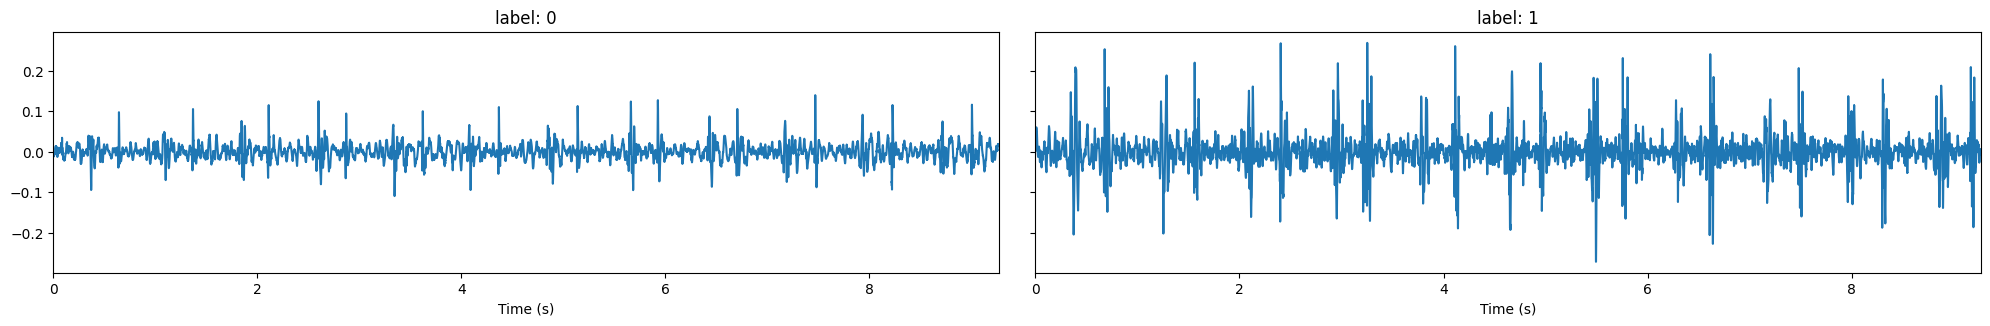

In [73]:
FREQUENCY = 2000  # Hz

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([1, 200], ax_arr):
    s = X[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    _ = ax.set_title(f"label: {y[ind]}")

For the subsequent study, we select only 6 elements (3 from each classe) from the complete data set.

In [74]:
sub_sample = [0, 1, 2, 190, 191, 192]  # 3 Normal, 3 Abnormal
sub_X = np.take(
    X, sub_sample, axis=0
).squeeze()  # shape (n_series, n_samples)
sub_y = np.take(y, sub_sample, axis=0)  # shape (n_series,)

# normalize signals (zero mean, unit variance).
sub_X -= sub_X.mean(axis=1).reshape(-1, 1)
sub_X /= sub_X.std(axis=1).reshape(-1, 1)

Let's zoom to see in more details the events of interest.

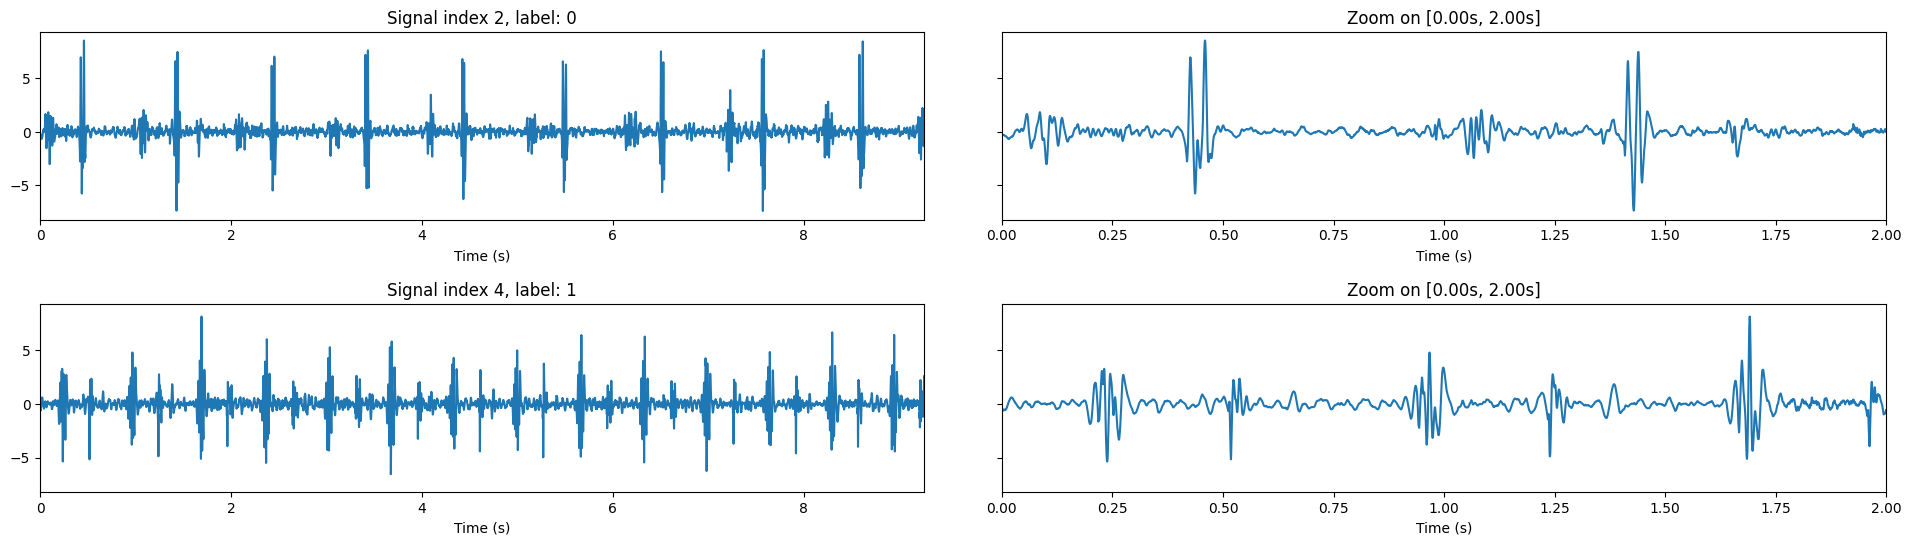

In [75]:
inds = [2, 4]  # indices des signaux à afficher
fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=(20, 6), sharey=True)
fig.tight_layout(pad=4)

for row, ind in enumerate(inds):
    signal = sub_X[ind]
    label = sub_y[ind]
    n_samples = signal.size
    tt = np.arange(n_samples) / FREQUENCY

    # Signal complet
    ax = ax_arr[row, 0]
    ax.plot(tt, signal)
    ax.set_xlabel("Time (s)")
    ax.set_xlim(0, n_samples / FREQUENCY)
    ax.set_title(f"Signal index {ind}, label: {label}")

    # Zoom sur un segment
    ax = ax_arr[row, 1]
    start, end = 0, 4000  # ajuster selon le zoom souhaité
    ax.plot(tt[start:end], signal[start:end])
    ax.set_xlim(tt[start], tt[end])
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Zoom on [{start/FREQUENCY:.2f}s, {end/FREQUENCY:.2f}s]")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Roughly, what is the duration of the important phenomenon (the heartbeat)?</p>
</div>

We can take 1 s in general

To compare the signals at a finer scale, we need to extract their elementary atoms. One way to achieve this is through Convolutional Dictionary Learning (CDL).

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N$ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad (1/2)\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$$

where $\mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the parameters that a user must calibrate when using CDL?</p>
</div>

We should calibrate  lambda and K

We can now apply CDL on a single signal.

In [111]:
# Select a signal
signal = sub_X[2]
data = signal[np.newaxis, :]  # shape (1, n_samples)

In [112]:
# Parameters to change
n_atoms = 3  # K
atom_length = 500  # L
penalty = 4  # lambda

In [113]:
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=data,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=3,
    verbose=1)

V_0/30 

.............................


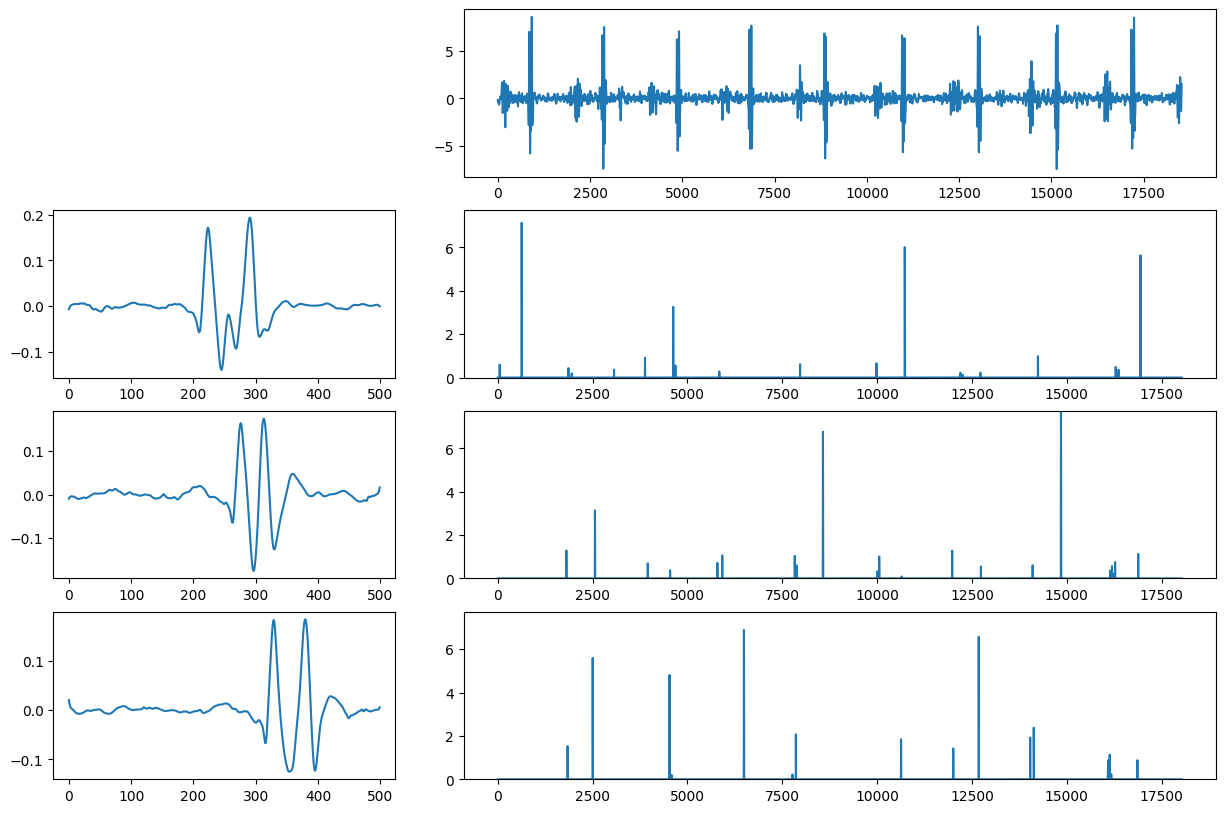

In [114]:
# plot the results
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())

Atomes are very similar

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does the number of activation evolve when the sparsity penalty changes?</p>
</div>

In general, more pernalty, less activations becuase zk norm diminish

0 activation for large penalty, large defect of CDL

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Looking at the sparse codes, can you tell:</p>
    <ul>    
    <li>How many times each atom is activated?</li>
    <li>What is the compression rate (number of non-zero coefficients in the sparse codes / signal length)?</li>
    </ul>
</div>

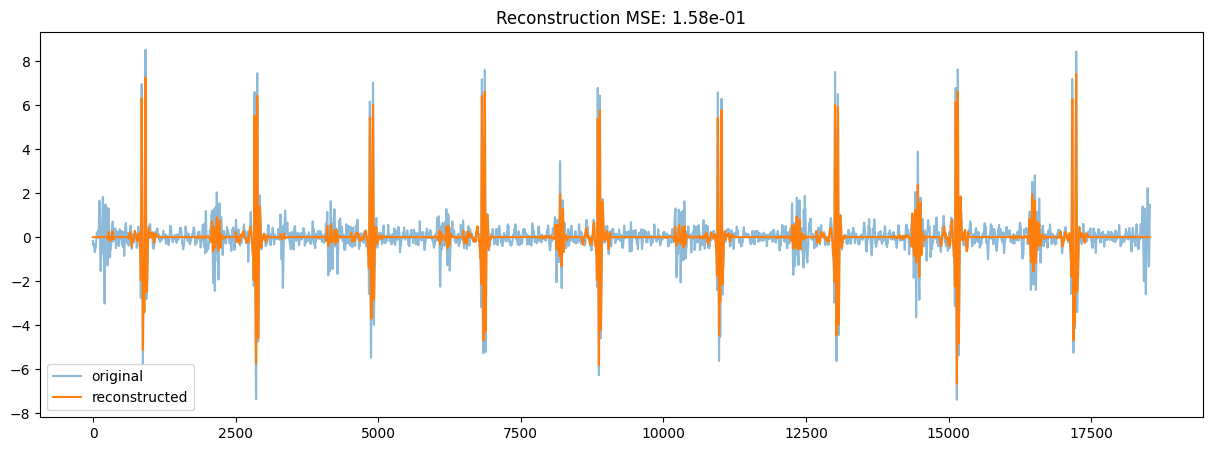

In [115]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = construct_X(z_hat, d_hat).squeeze()

figsize=(15, 5)
fig, ax = plt.subplots(figsize=figsize)
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt, reconstruction, label="reconstructed")

ax.set_title(f"Reconstruction MSE: {np.mean((signal - reconstruction)**2):.2e}")

_ = plt.legend()

In [116]:
activations_per_atom = (z_hat != 0).sum(axis=(1, 2))
compression_rate = (z_hat != 0).sum() / z_hat.size  # def of compression rate
print(activations_per_atom)
print(compression_rate)


[817 934 781]
0.04680827463812323


4 percents, very good, dividded the number of points by 100

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does reconstruction error evolve when the sparsity penalty changes?</p>
</div>

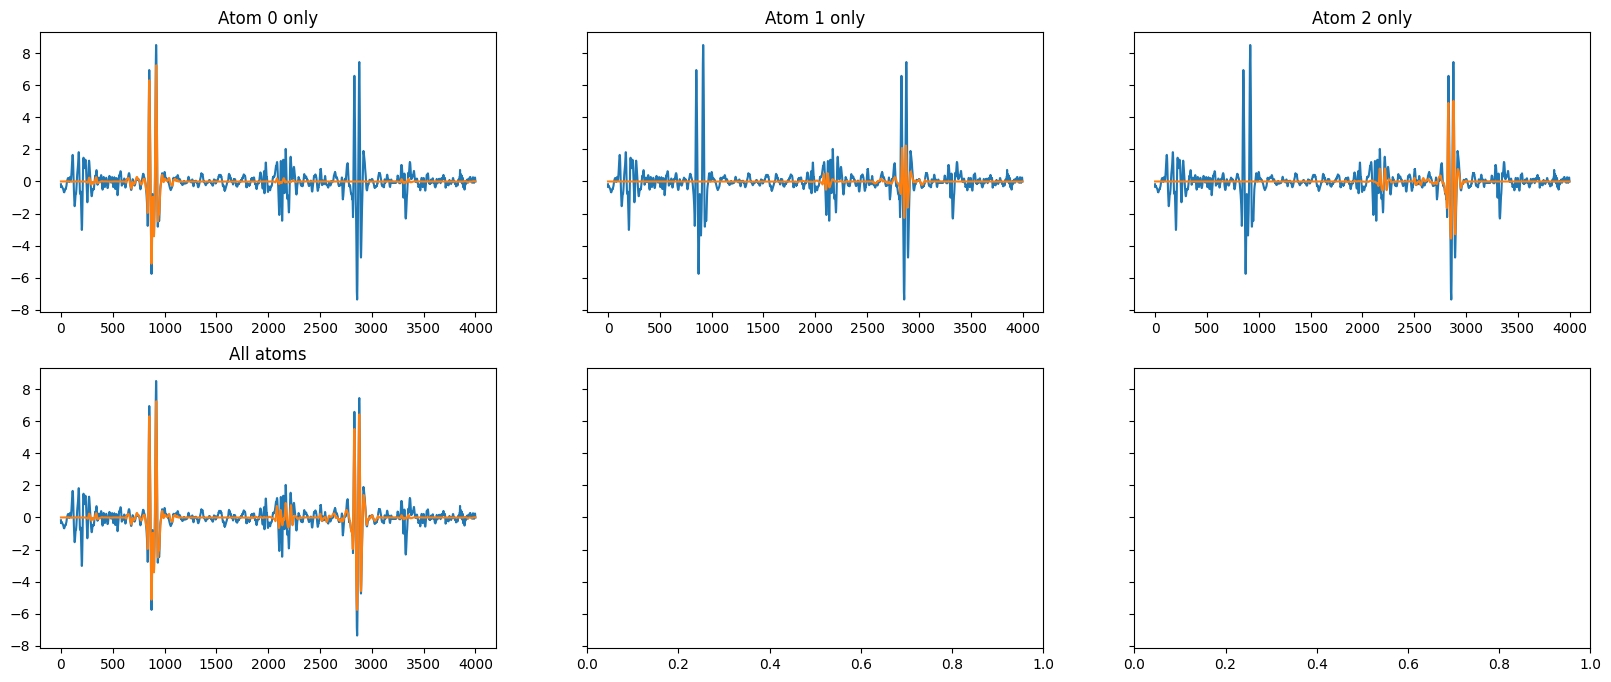

In [117]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k in range(n_atoms):
    ax = ax_arr.flatten()[k]
    reconstruted_with_one_atom = construct_X(
        z_hat[k, np.newaxis, :, :], d_hat[k, np.newaxis, :]
    ).squeeze()
    ax.plot(range(start, end), signal[start:end])
    ax.plot(
        range(start, end),
        reconstruted_with_one_atom[start:end],
    )
    ax.set_title(f"Atom {k} only")

ax = ax_arr.flatten()[n_atoms]
ax.plot(range(start, end), signal[start:end])
ax.plot(
    range(start, end),
    reconstruction[start:end],
)
_ = ax.set_title(f"All atoms")

Les atomes sont un peu mixés, en tant qu'algo de clustering ça va pas super bien marcher

Penalty: 1.2589254117941673
V_0/30 

.............................
Penalty: 2.113489039836647
V_0/30 .............................
Penalty: 3.548133892335755
V_0/30 .............................
Penalty: 5.956621435290105
V_0/30 
Penalty: 10.0
V_0/30 

/home/janis/4A/timeseries/.venv/lib/python3.11/site-packages/alphacsc/learn_d_z.py:175: UserWarning: Regularization parameter `reg` is too large and all the activations are zero. No atoms has been learned.
  warnings.warn("Regularization parameter `reg` is too large "


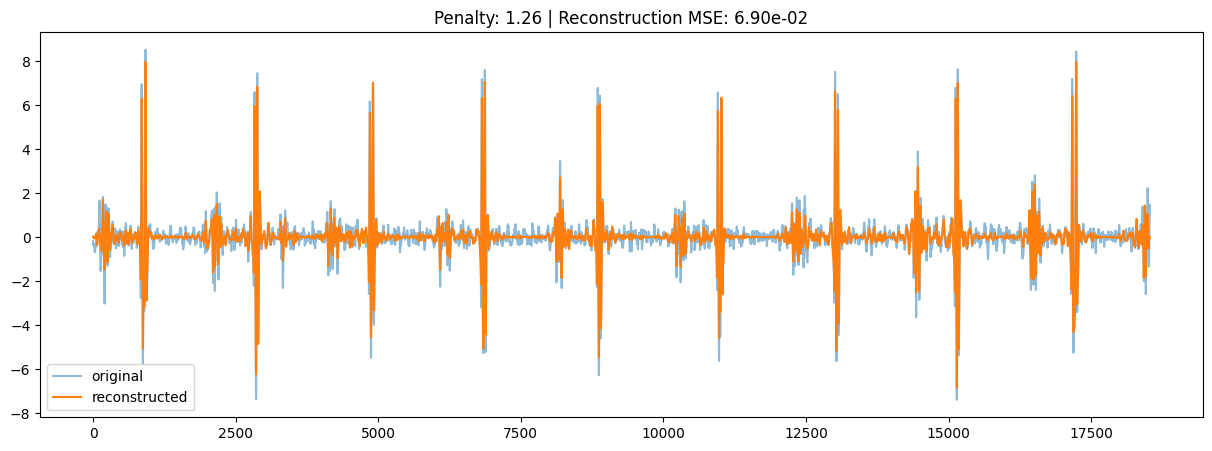

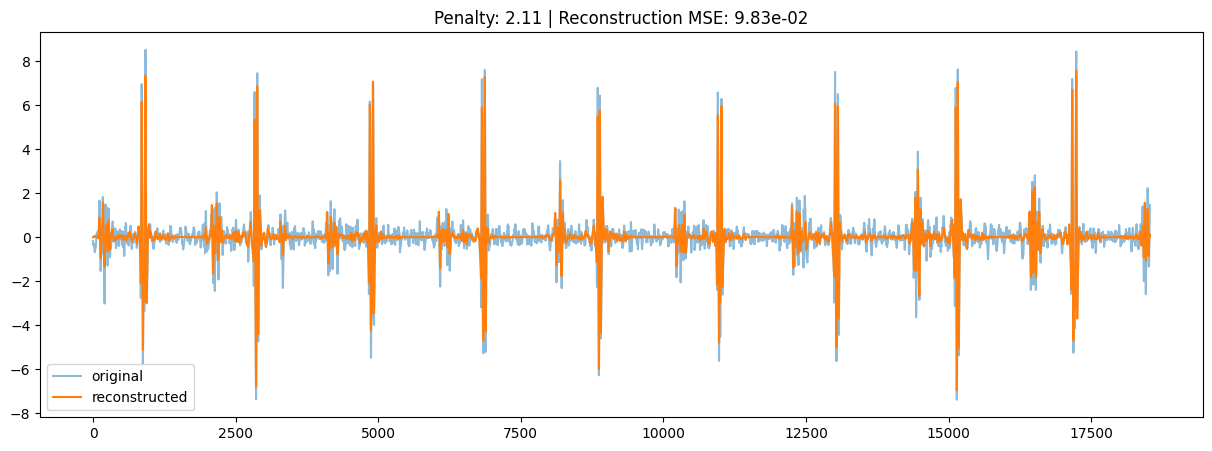

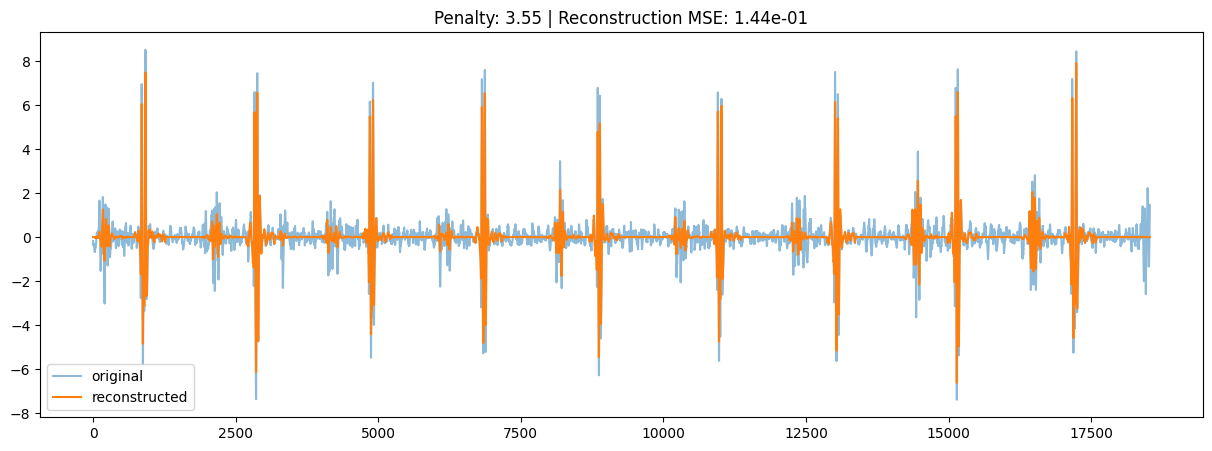

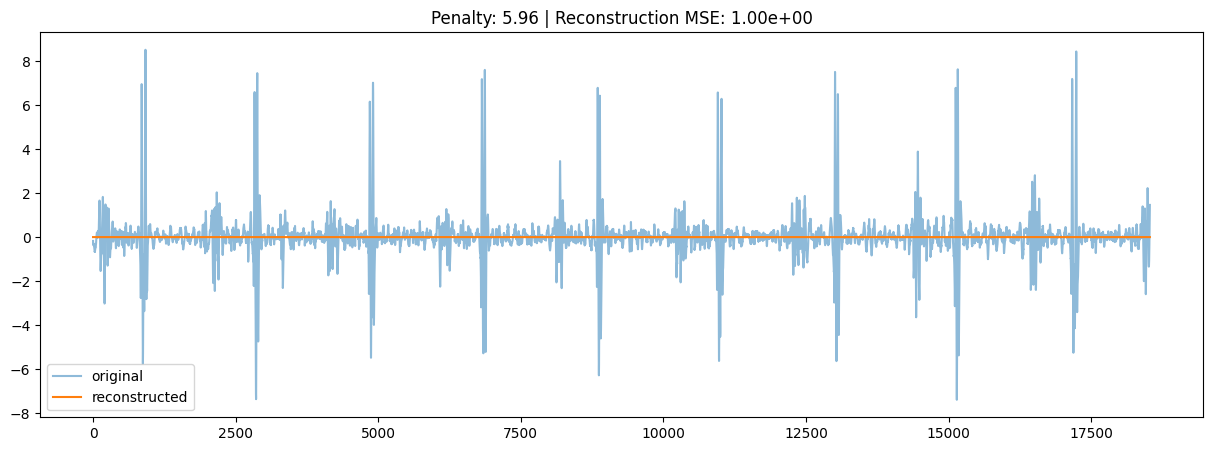

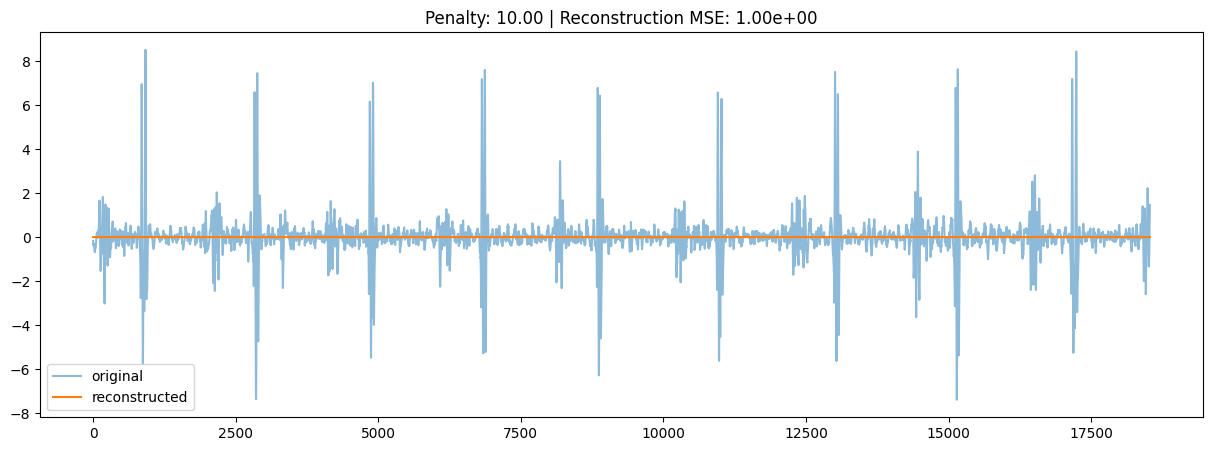

In [120]:
for penalty in np.logspace(0.1, 1, num=5):  # 5 values from 10^0=1 to 10^1=10 (log scale)
    # learning a dictionary and codes
    print(f"Penalty: {penalty}")
    pobj, _, d_hat, z_hat, _ = learn_d_z(
        X=data,
        n_atoms=n_atoms,
        n_times_atom=atom_length,
        reg=penalty,
        n_iter=30,
        n_jobs=3,
        verbose=1
    )

    # Reconstruction with the dictionary and the sparse codes
    reconstruction = construct_X(z_hat, d_hat).squeeze()

    figsize = (15, 5)
    fig, ax = plt.subplots(figsize=figsize)
    tt = np.arange(signal.shape[0])
    ax.plot(tt, signal, label="original", alpha=0.5)
    ax.plot(tt, reconstruction, label="reconstructed")

    ax.set_title(f"Penalty: {penalty:.2f} | Reconstruction MSE: {np.mean((signal - reconstruction) ** 2):.2e}")

    _ = plt.legend()

Reconstruction error decrease with the penalty, further investigations to do

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Rerun the dictionary learning and sparse coding. What do you observe on the motif shape? And the reconstruction error?</p>
</div>

it changes, sometimes we can have only 1 atom depending, not convex for the 2 in the same times, l'initialisation va jouer sur le résultat final,
it takes an init at the beginning and depending on the init, the algorithm is not stable at all, for every iterations it can change

## CDL on the whole data set

In this section, we apply CDL on the whole data set.

In [124]:
# In the following, we fix the number of atoms and their length
n_atoms = 5
atom_length = 1500
penalty = 4

Dictionary learning.

In [ ]:
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=sub_X,
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    verbose=1,
    n_jobs=3,
    n_iter=30,
)

V_0/30 .............................

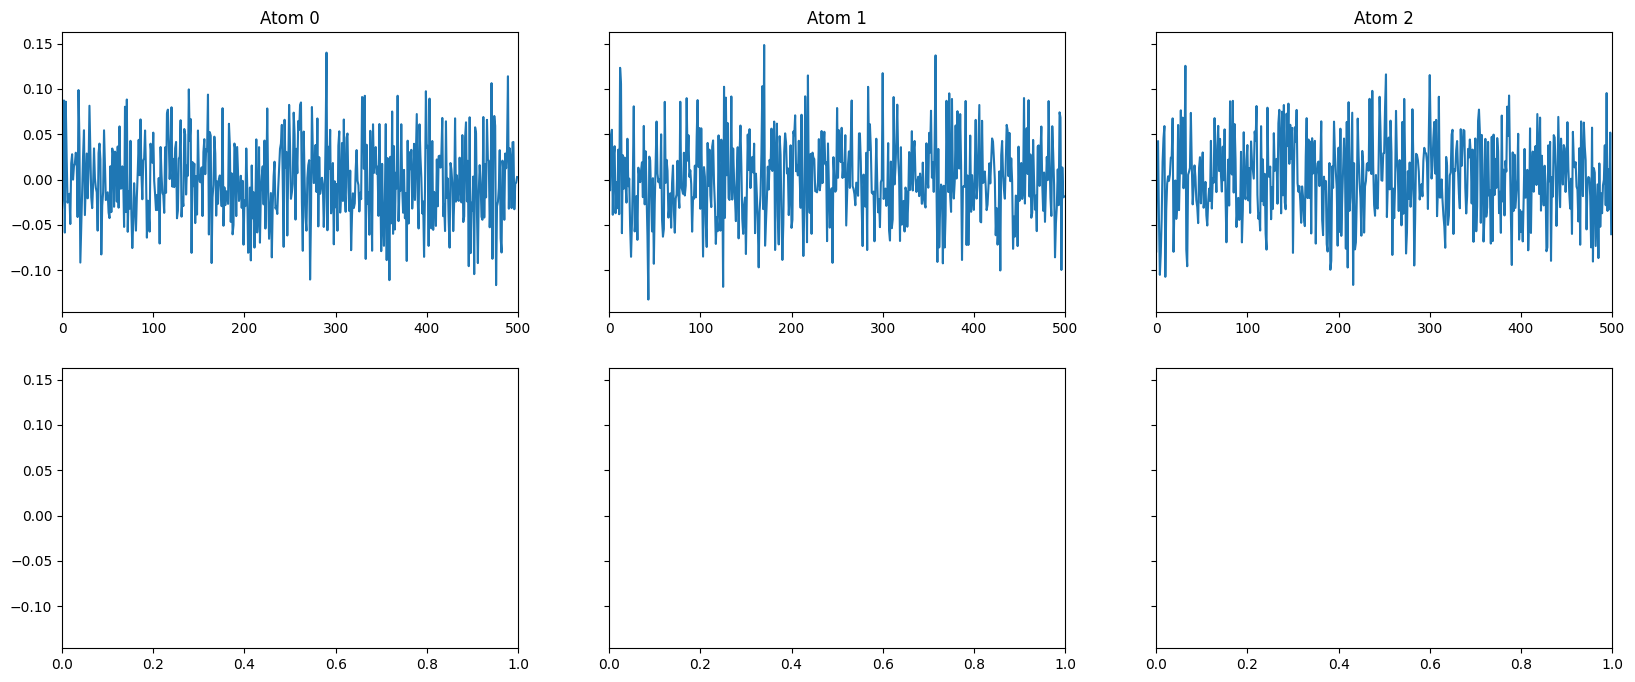

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for k, (atom, ax) in enumerate(zip(d_hat, ax_arr.flatten())):
    ax.plot(atom)
    ax.set_xlim(0, atom.size)
    ax.set_title(f"Atom {k}")

In [ ]:
for k, (label, signal) in enumerate(zip(sub_y, sub_X)):
    codes = z_hat[:, k, :]
    reconstruction = construct_X(codes[:, np.newaxis, :], d_hat).squeeze()
    error = np.mean((signal - reconstruction) ** 2)
    nnz_activations = (codes > 1e-3).sum()

    # select the used atoms
    most_used_atoms_activations, most_used_atoms_indexes = get_n_largest(
        (codes > 1e-3).sum(axis=1), n_largest=1
    )
    most_used_atom_msg = ", ".join(
        f"{ind} ({acti*100/nnz_activations:.1f}%)"
        for (acti, ind) in zip(
            most_used_atoms_activations, most_used_atoms_indexes
        )
    )
    print(
        f"Label: {label}, MSE: {error:.2f}, non-zero activations: {nnz_activations}, most used atoms: {most_used_atom_msg}"
    )

Label: 0, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)
Label: 0, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)
Label: 0, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)
Label: 1, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)
Label: 1, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)
Label: 1, MSE: 1.00, non-zero activations: 0, most used atoms: 2 (nan%)


/tmp/ipykernel_12298/311955909.py:12: RuntimeWarning: invalid value encountered in scalar divide
  f"{ind} ({acti*100/nnz_activations:.1f}%)"


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Based on the results, does this approach appear suitable for effectively clustering such time series?</p>
</div>

# 3. Clustering via Feature Selection

The final approach we consider in this lab is more closely related to traditional machine learning methods. It consists in extracting a well-chosen set of features from the time series and subsequently applying standard clustering algorithms.


In the following, we will use the same dataset as before. Let’s start by examining in detail the different features that can be extracted from an example time series.

In [ ]:
ind=0
signal=X[0]
label = y[ind]
n_samples = signal.shape[0]
print(label)

## 3.a. Statistical features

### Moment and percentiles

In [ ]:
def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()
    res_dict["mean"] = signal.mean()
    res_dict["std"] = signal.std()
    res_dict["min"] = signal.min()
    res_dict["max"] = signal.max()    
    return res_dict

In [ ]:
get_distribution_features(signal)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Rewrite in the following cell, the function <tt>get_distribution_features(signal)->dict</tt> so that is also computes the kurtosis (moment of order 4), the skew (measure of the asymmetry of the proba. distrib.) available in the <tt>scipy.stats</tt> module and the 25%, 50% and 75% percentiles.</p>
</div>

In [ ]:
from scipy.stats import skew, kurtosis

def get_distribution_features(signal: np.ndarray) -> dict:
    res_dict = dict()  
    return res_dict

In [ ]:
get_distribution_features(signal)

### Autocorrelation

For a signal $x\in\mathbb{R}^N$ with $N$ samples, the autocorrelation with lag $m$ is defined as follows:

$$
\hat{\gamma}[m] := \frac{1}{N-|m|} \sum_{n=0}^{N -|m|-1} x[n]x[n+m].
$$

Note that in practice, peaks observed in the autocorrelation function correspond to repetitions in the signal, and therefore reveal its underlying periodicity.

Let us plot the autocorrelation of a sound signal.

In [ ]:
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(acf(signal, nlags=200, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
ax.set_title('Autocorrelation')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelation')
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>We would like to compute the largest positive and negative autocorrelation peaks (excluding the trivial one at lag 0), together with their associated lags in Hz. How can you convert a lag expressed in number of samples into a lag expressed in Hz?</p>
</div>

In [ ]:
def samples_to_hz(lag_in_samples, FREQUENCY):
    pass 

The autocorrelation features retained in the end consist of the full set of autocorrelation values, together with the amplitudes of the first negative and positive peaks and their corresponding lags.

Compute the autocorrelation features.

In [ ]:
def get_autocorr_features(signal: np.ndarray, n_lags: int = 200) -> dict:
    auto_corr = acf(signal, nlags=n_lags, fft=True)
    res_dict = dict()
    for lag, auto_corr_value in enumerate(auto_corr):
        res_dict[f"autocorrelation_{lag}_lag"] = auto_corr_value

    local_max, local_argmax = get_largest_local_max(auto_corr[1:], order=5)
    local_argmax += 1  # to account for the lag=0 removed before
    local_min, local_argmin = get_largest_local_max(-auto_corr[1:], order=5)
    local_min = -local_min
    local_argmin += 1  # to account for the lag=0 removed before
    res_dict["largest_local_max_autocorrelation"] = local_max
    res_dict["lag_largest_local_max_autocorrelation_Hz"] = samples_to_hz(local_argmax, FREQUENCY)
    res_dict["largest_local_min_autocorrelation"] = local_min
    res_dict["lag_largest_local_min_autocorrelation_Hz"] = samples_to_hz(local_argmin, FREQUENCY)
    return res_dict

In [ ]:
get_autocorr_features(signal, n_lags=100)

## 3.b Spectral features

Using the Discrete Fourier Transform (DFT), we can identify which frequencies are present in the signal and their associated amplitudes.

For a signal $x\in\mathbb{R}^N$ with $N$ samples, the $k$-th discrete fourier coefficient is defined as follows:

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j2\pi\frac{kn}{N}}.
$$
$X[k]$ corresponds to the DFT for the physical frequency
$$f[k]=k\frac{F_s}{N}$$


Plot the Fourier coefficients of a signal (y=absolute value, x=frequency) using `rfft()` and `rfftfreq()`.

In [ ]:
from scipy.fft import rfft, rfftfreq
fourier = abs(rfft(signal)) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

Compute the spectral features.

In [ ]:
def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""
    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for f_min, f_max in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.0f}-{f_max:.0f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

In [ ]:
get_fourier_features(signal, n_bins=10)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>The frequency features are not scaled. If the signal is normalized, do we need to?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> We have used regularly spaced frequency bins. What would be a better approach? </p>

</div>

## Concatenate all features

In the following cell, we write a function `get_features(signal: np.ndarray) -> dict` that computes all features from above.

In [ ]:
def get_features(signal: np.ndarray) -> dict:
    res_dict = dict()

    # stats
    res_dict.update(get_distribution_features(signal))

    # spectral
    signal -= signal.mean()
    signal /= signal.std()
    res_dict.update(get_fourier_features(signal, n_bins=50))

    # autocorrelation
    res_dict.update(get_autocorr_features(signal, n_lags=200))

    return res_dict

In [ ]:
get_features(signal)

Compute all features over the data set.

In [ ]:
all_features = pd.DataFrame(
    [get_features(signal) for signal in X]
)

In [ ]:
all_features.head()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

## Feature selection

### Unsupervised selection

#### Sanity checks 

**Low variance threshold**

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
all_features.std().sort_values().plot(ax=ax)

# change the height of the horizontal line here
ax.axhline(0.1, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Choose a variance threshold (name it <tt>variance_threshold</tt>).</p>
</div>

In [ ]:
variance_threshold = ...

Be careful when dropping low variance features, they might still be informative. Quickly check that it makes sense to drop them.

In [ ]:
low_variance_features = all_features.std() < variance_threshold
low_variance_features = low_variance_features[
    low_variance_features
].index.to_numpy()
print(f"There are {len(low_variance_features)} features to drop.")
print(low_variance_features)

The following cell drops the low-variance features. Only execute it when you are sure of the features you want to remove.

In [ ]:
all_features.drop(columns=low_variance_features, inplace=True, errors="ignore")
print(f"There are {all_features.shape[1]} features left.")

**Check outliers**

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Some features have larger variations than others: which ones are they? (Create a list <tt>features_to_check</tt>.) Show the associated histograms.</p>
</div>

In [ ]:
all_features.std().sort_values()

In [ ]:
features_to_check = [...]

In [ ]:
for feature in features_to_check:
    #plot histogram

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Check the outliers. Is there something we can do to remediate this issue?</p>
</div>

In [ ]:
for feature in features_to_check:
    mean_val = all_features[feature].mean()
    std_val = all_features[feature].std()
    lower = mean_val - 3 * std_val
    upper = mean_val + 3 * std_val

    # clip les valeurs en dehors des bornes
    all_features[feature] = all_features[feature].clip(lower, upper)

In [ ]:
for feature in features_to_check:
    all_features[feature].hist(bins=30, figsize=(15, 5))
    plt.title(feature)
    plt.plot()
    plt.show()

**Multicollinearity**

Multicollinearity degrades numerical stability and interpretability.
Compute the correlation.
Features with a correlation above a threshold are grouped together in a cluster.
We then choose a single feature from each cluster.

In [ ]:
correlation_threshold = 0.8

In [ ]:
corr = pdist(all_features.to_numpy().T, metric="correlation")  # distance matrix
plt.imshow(squareform(corr))
plt.colorbar()
plt.title("Correlation distance matrix")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
corr_linkage = hierarchy.average(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, ax=ax, color_threshold=1 - correlation_threshold
)

In [ ]:
# compute the clusters
cluster_ids = hierarchy.fcluster(
    corr_linkage, 1 - correlation_threshold, criterion="distance"
)

# print the largest clusters
largest_cluster_ind = np.bincount(cluster_ids).argmax()
print(
    f"The largest cluster is {all_features.columns[cluster_ids==largest_cluster_ind].tolist()}."
)

# for each cluster, only keep the first feature
keep_features = list()
for cluster in np.unique(cluster_ids):
    cluster_indexes = np.where(cluster_ids == cluster)[0]
    keep_features.append(all_features.columns[cluster_indexes[0]])

In [ ]:
# Reduce the number of features
all_features = all_features[keep_features]

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> How many features do we have in the end?</p>
</div>

**PCA**

In [ ]:
all_features_centered = all_features.to_numpy()

all_features_centered -= all_features_centered.mean(axis=0)
all_features_centered /= all_features_centered.std(axis=0)


pca = PCA(n_components=2).fit(all_features_centered)

In [ ]:
# select the 5 most important features (with highest norm).
top_features_for_pca = np.linalg.norm(pca.components_, axis=0).argsort()[-10:]

for feature_ind in top_features_for_pca:
    msg = f"{all_features.columns[feature_ind]}: {(pca.components_.T[feature_ind]**2).sum():.3f}"
    print(msg)

In [ ]:
# plot the 2D projection of the top 10 features
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("equal")
for feature_ind in top_features_for_pca:  # normaliser par la variance
    dx, dy = pca.components_.T[feature_ind]
    ax.plot([0, dx], [0, dy], label=all_features.columns[feature_ind])
ax.set_xlabel(f"PC1 ({pca.explained_variance_[0]:.1f}% of variance)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_[1]:.1f}% of variance)")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Given a target variance threshold, determine the minimum number of principal components (n_components) required to reach or exceed this level of explained variance using PCA</p>
</div>

In [ ]:
variance_threshold = 0.8

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Using the number of components (n_components) determined previously, rerun PCA with this number of components, transform the dataset into the reduced space, and then apply K-means clustering on the transformed data.</p>
</div>

### Supervised selection

In the supervised setting, we can further refine feature selection by taking the labels into account, keeping only the features that are most informative for the prediction task.

Three main classes of methods:

- **Filter methods.** We test the adequacy of the feature with the annotations, thanks to several criterion/scores (e.g. correlation).
- **Wrapper methods.** We test the features on a supervised classification task, by trying several combinations. The best features are kept.
- **Embedded methods.** Mixed approaches where we jointly infer the relevance of the features and classify the data (decision tree, sparse methods...)

**Filter methods**

If a feature is highly correlated with a label, it can help achieve good classification performance.

For classification tasks, we can use the ANOVA test:

In [ ]:
labels = y
statistics, pvalues = f_oneway(
    all_features[labels == "0"], all_features[labels == "1"]
)

In [ ]:
for ind in statistics.argsort()[::-1]:
    print(f"{all_features.columns[ind]}: {statistics[ind]:.3f}")

**Wrapper methods**

For a given learning algorithm, wrapper methods repeatedly select a subset of features and evaluate the selected features. Several procedures exist to select a subset but the most common are greedy and iterative; they either remove (backward selection) or add a feature (forward selection) sequentially.

In [ ]:
# At each steps, SequentialFeatureSelector adds the best scoring feature to
# the set of selected features.
# For a given estimator, the score is computed with cross-validation.
knn = KNeighborsClassifier(n_neighbors=5)
sfs = SequentialFeatureSelector(
    knn, n_features_to_select=20, cv=5, scoring=make_scorer(accuracy_score)
)
sfs.fit(all_features, labels)

print("Selected features:")
print(all_features.columns[sfs.get_support()].tolist())

### Embedded methods

Such methods use the intrinsic structure of a learning algorithm to embed feature selection into the underlying model.

In [ ]:
rf = RandomForestClassifier().fit(all_features, labels)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Print features in descending order of importance, measured by the random forest feature importance (see the <tt>feature_importances_</tt> attribute).</p>
</div>